# Import Libraries

In [5]:
import os
import pandas as pd
import numpy as np
import glob
import imageio
import matplotlib.pyplot as plt
import sklearn


# SET PATH 

In [6]:
project_path = r"D:\minor 2\datasets\New folder"

## Load file

In [2]:
import cv2
def load_file(file_path, label):
    # Include the project path
    
    
    # Declare the folder name
    folder_name = file_path.split("/")[-1]
    
    # Declare output list
    out_list = []
    
    # Load every file .png format
    for image_path in glob.glob(file_path + "/*.jpg"):
        # Read image file
        image = cv2.imread(image_path)
        #    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image= cv2.resize(image,(224,224))
        
        # Declare temporary dict dtype
        temp = {}
        
        # Set the file name
        temp["name"] = image_path.split("/")[-1]
        
        # Set the file label, 0 for non defect. 1 for defect
        temp["label"] = label
        # There are somes images are tensor dtype
        # Thus I fix by selecting only a tensor index zero
        try:   
            temp["data"] = image[:,:,0].astype("int") 
        except:
            # Normal case
            temp["data"] = image.astype("int")
        
        # Append temp into output list
        out_list.append(temp)
    
    # Print process status by checking size of output list
    if len(out_list) == 0:
        print("loading files from folder: {} is   failed".format(folder_name))
    else:
        print("loading file from folder: {} is successful".format(folder_name))
    
    # Convert list into numpy array dtype
    return np.array(out_list)

# LOAD ImAGeS

In [3]:
Hole = project_path + "/holes"
Lines =  project_path + "/lines"



# TARGET OUTPUT Hole = 1 and Line = 0

In [7]:
Hole_images = load_file(file_path=Hole, label=1)
Lines_images = load_file(file_path=Lines, label=0)


loading file from folder: holes is successful
loading file from folder: lines is successful


# TOTAL NUMBER OF IMAGES FOR BOTH Classes

In [8]:
print("Hole.shape: {}\nLines.shape: {}\n".format(Hole_images.shape, Lines_images.shape))

Hole.shape: (276,)
Lines.shape: (204,)



In [9]:
np.random.shuffle(Hole_images)
np.random.shuffle(Lines_images)

In [10]:
class_size = Hole_images.shape[0] if Hole_images.shape[0] <= Lines_images.shape[0] else Lines_images.shape[0]
class_size

204

In [11]:
dataset = np.concatenate((Hole_images[:class_size], Lines_images[:class_size]))

In [12]:
X = np.empty([dataset.shape[0], 224, 224]).astype(int)

In [13]:
y = np.empty(dataset.shape[0]).astype(int)

In [14]:
for i in range(dataset.shape[0]):
    X[i] = dataset[i]["data"]
    y[i] = dataset[i]["label"]

In [15]:
X = X.reshape(X.shape[0], 224, 224, 1)

# Unique Images in Both Categories

In [16]:
np.unique(y, return_counts=True)

(array([0, 1]), array([204, 204], dtype=int64))

# CNN

In [17]:
!pip install tensorflow
import tensorflow

In [19]:
from tensorflow.keras import datasets, layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
def create_model(image_shape=(224, 224, 1), print_summary=False):
    # Initial model
    model = models.Sequential()
    
    # CONV layer: filter 32, stride 5x5
    model.add(layers.Conv2D(32, (5, 5), padding="same", kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
 
    # CONV layer: filter 64, stride 3x3
    model.add(layers.Conv2D(64, (3, 3), padding="same", kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
 
    # CONV layer: filter 128, stride 3x3
    model.add(layers.Conv2D(128, (3, 3), padding="same", kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # CONV layer: filter 256, kernel 3x3
    model.add(layers.Conv2D(256, (3, 3), padding="same", kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
 
    # Global Average Pooling
    model.add(layers.GlobalAveragePooling2D())
 
    # Fully connected layer -> nn layer with 64 nodes
    model.add(layers.Dense(128))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.Dropout(0.5))
    # Fully connected layer -> nn layer with 64 nodes
    model.add(layers.Dense(64))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.Dropout(0.5))
 
    # Output layer
    model.add(layers.Dense(1, activation="sigmoid"))
 
    # Set model compiler
    model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"])
 
    # Show the CNN model detail
    if print_summary:
        model.summary()
    
    return model

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score,f1_score, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns

predic = []
def train_model(model, xtrain, ytrain, xval, yval, n_epoch, batch_size,index):
    # Train CNN model
    # Batch size to reduce memory usage
    # Set early stopping to avoid overfitting
 
    earlystopping = EarlyStopping(monitor="val_loss", patience=5)
    model_checkpoint = ModelCheckpoint(f'model_fold_{index+1}.keras', save_best_only=True, monitor='val_loss')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
    
    history = model.fit(xtrain, ytrain, epochs=n_epoch, batch_size=batch_size, shuffle = True, validation_split=0.2, callbacks=[earlystopping,model_checkpoint,reduce_lr])
    preds = np.round(model.predict(xval),0)
    predic.append(preds)
    
    print("Accuracy on Testing Data -> ",accuracy_score(yval, preds))
    print("F1-Score" ,f1_score(yval, preds, average='weighted'))
    print("Precision" ,precision_score(yval, preds, average='weighted'))
    print("Recall" ,recall_score(yval, preds, average='weighted'))
    
    print('Confusion Matrix: ')
    cm = confusion_matrix(yval, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    
    # model.save("CNN Model fold{}.h5".format(index+1))
    return history

Training on fold 1/2…
(204, 224, 224, 1)
(204,)
ytrain: number of samples each class: (array([0, 1]), array([102, 102], dtype=int64))
yval: number of samples each class: (array([0, 1]), array([102, 102], dtype=int64))
Training new iteration on 204 training samples, 204 validation samples, this may be a while…
Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 498ms/step - accuracy: 0.4967 - loss: 1.1185 - val_accuracy: 0.9756 - val_loss: 0.3656 - learning_rate: 0.0010
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 577ms/step - accuracy: 0.7352 - loss: 0.8388 - val_accuracy: 0.9756 - val_loss: 0.3726 - learning_rate: 0.0010
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 435ms/step - accuracy: 0.8357 - loss: 0.7415 - val_accuracy: 0.9756 - val_loss: 0.3997 - learning_rate: 0.0010
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 537ms/step - accuracy: 0.8111 - loss: 0.7525 - val_accuracy: 0.9756 - val_loss: 0.4506 - learning_rate: 0.0010
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 495ms/step - accuracy: 0.7538 - loss

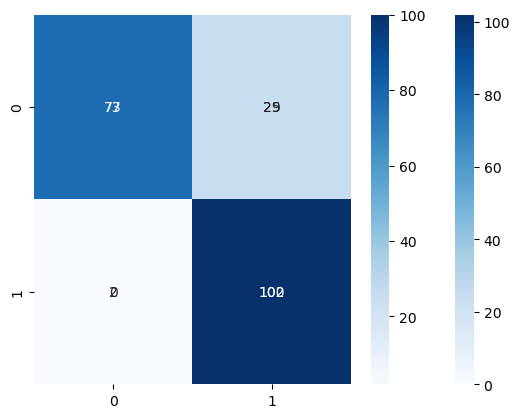

In [21]:
from sklearn.model_selection import StratifiedKFold

# Set number of split
kfold_splits = 2
# Set number of epoch
n_epoch = 10
# Set batch size
batch_size = 8
# Create StratifiedKFold
skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
    print("Training on fold {}/{}…".format(index+1, kfold_splits))
    
    # Declare x train and x validate
    xtrain, xval = X[train_indices], X[val_indices]
    print(xtrain.shape)
    
    # Declare y train and y validate
    ytrain, yval = y[train_indices], y[val_indices]
    print(ytrain.shape)
    
    # Print number of class portion
    print("ytrain: number of samples each class: {}".format(np.unique(ytrain, return_counts=True)))
    print("yval: number of samples each class: {}".format(np.unique(yval, return_counts=True)))
    
    # Clear the model
    model = None
    # Create cnn model
    model = create_model()
    print("Training new iteration on {} training samples, {} validation samples, this may be a while…".format(xtrain.shape[0], xval.shape[0]))
 
# # Define callbacks
#     early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#     model_checkpoint = ModelCheckpoint(f'model_fold_{index+1}.keras', save_best_only=True, monitor='val_loss')
    
# Train CNN model
    history = train_model(model, xtrain, ytrain, xval, yval, n_epoch, batch_size, index)
    print("— — — — — "*5)

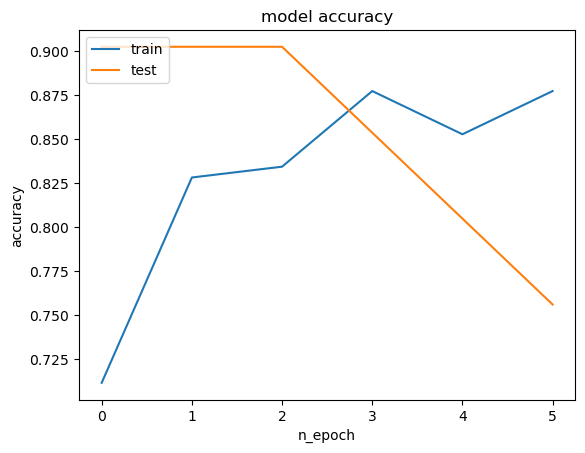

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('n_epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

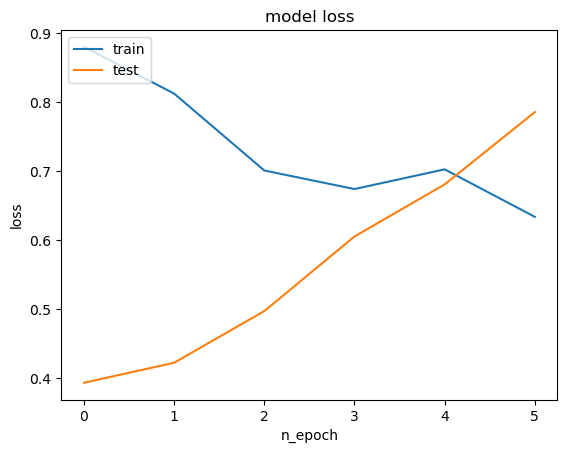

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('n_epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()